In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset

def subsample_dataset(dataset, num_samples, seed=42):
    torch.manual_seed(seed)
    indices = torch.randperm(len(dataset))[:num_samples]
    return Subset(dataset, indices)

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

full_train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# 5,000개만 사용
train_dataset_small = subsample_dataset(
    full_train_dataset,
    num_samples=5000,
    seed=42
)

train_loader = DataLoader(
    train_dataset_small,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False
)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm 

In [5]:
class CNN_CIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 24, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 48, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(48 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

class MLP_CIFAR(nn.Module):
    def __init__(self, patch=4, hidden=512, num_classes=10):
        super().__init__()
        self.patch = patch
        dim = 3 * patch * patch

        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )

        self.cls = nn.Linear(hidden, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch

        x = x.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, -1, C*p*p)

        h = self.net(x).mean(dim=1)
        return self.cls(h)

In [6]:
import copy

def fine_tune(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return (
        model,
        copy.deepcopy(model.state_dict()),
        train_loss / len(train_loader)
    )

In [7]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [8]:
def kd_loss(student_logits, teacher_logits, T=2.0):
    return kl_loss(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)

def studygroup(
    model1,
    model2,
    optimizer1,
    optimizer2,
    train_loader,
    device,
    T=2.0
):
    model1.train()
    model2.train()

    train_loss1 = 0.0
    train_loss2 = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        logits1 = model1(x)
        logits2 = model2(x)

        pred1 = logits1.argmax(dim=1)
        pred2 = logits2.argmax(dim=1)

        correct1 = pred1 == y
        correct2 = pred2 == y

        # index 정의
        index1 = correct1 & ~correct2   # model1 
        index2 = ~correct1 & correct2   # model2 
        index3 = ~(index1 | index2)    

        # ----------------------
        # model1 update
        # ----------------------
        loss1 = 0.0
        if index2.any():
            loss1 += kd_loss(
                logits1[index2],
                logits2[index2].detach(),
                T=T
            )
        if index3.any():
            loss1 += ce_loss(
                logits1[index3],
                y[index3]
            )

        loss1.backward()
        optimizer1.step()

        # ----------------------
        # model2 update
        # ----------------------
        loss2 = 0.0
        if index1.any():
            loss2 += kd_loss(
                logits2[index1],
                logits1[index1].detach(),
                T=T
            )
        if index3.any():
            loss2 += ce_loss(
                logits2[index3],
                y[index3]
            )

        loss2.backward()
        optimizer2.step()

        train_loss1 += loss1.item()
        train_loss2 += loss2.item()

    return (
        model1,
        model2,
        copy.deepcopy(model1.state_dict()),
        copy.deepcopy(model2.state_dict()),
        train_loss1 / len(train_loader),
        train_loss2 / len(train_loader)
    )

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            preds = outputs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [9]:
from tqdm.notebook import tqdm

def train_baseline(
    model,
    optimizer,
    criterion,
    train_loader,
    test_loader,
    device,
    epochs,
    log_dict
):
    for epoch in tqdm(range(epochs)):
        model, _, train_loss = fine_tune(
            model,
            optimizer,
            criterion,
            train_loader,
            device
        )

        test_acc = evaluate(model, test_loader, device)

        log_dict["train_loss"].append(train_loss)
        log_dict["test_acc"].append(test_acc)

        print(
            f"[Baseline][{epoch:02d}] "
            f"Loss={train_loss:.4f}, Acc={test_acc:.4f}"
        )

def train_studygroup(
    model1,
    model2,
    optimizer1,
    optimizer2,
    train_loader,
    test_loader,
    device,
    epochs,
    log1,
    log2,
    T=2.0
):
    for epoch in tqdm(range(epochs)):
        model1, model2, _, _, loss1, loss2 = studygroup(
            model1,
            model2,
            optimizer1,
            optimizer2,
            train_loader,
            device,
            T=T
        )

        acc1 = evaluate(model1, test_loader, device)
        acc2 = evaluate(model2, test_loader, device)

        log1["train_loss"].append(loss1)
        log1["test_acc"].append(acc1)

        log2["train_loss"].append(loss2)
        log2["test_acc"].append(acc2)

        print(
            f"[Studygroup][{epoch:02d}] "
            f"CNN Loss={loss1:.4f}, Acc={acc1:.4f} | "
            f"MLP Loss={loss2:.4f}, Acc={acc2:.4f}"
        )


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2000
criterion = nn.CrossEntropyLoss()

cnn_master = CNN_CIFAR().to(device)
mlp_master = MLP_CIFAR().to(device)

cnn_init_state = copy.deepcopy(cnn_master.state_dict())
mlp_init_state = copy.deepcopy(mlp_master.state_dict())

In [11]:
def init_log():
    return {
        "train_loss": [],
        "test_acc": []
    }
logs = {
    "baseline_cnn": init_log(),
    "baseline_mlp": init_log(),
    "studygroup_cnn": init_log(),
    "studygroup_mlp": init_log(),
    "individual_cnn1": init_log(),
    "individual_cnn2": init_log(),
    "individual_mlp1": init_log(),
    "individual_mlp2": init_log()
}

In [12]:
cnn_base = CNN_CIFAR().to(device)
cnn_base.load_state_dict(cnn_init_state)
opt_cnn_base = torch.optim.Adam(cnn_base.parameters(), lr=1e-3)

train_baseline(
    cnn_base,
    opt_cnn_base,
    criterion,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["baseline_cnn"]
)

mlp_base = MLP_CIFAR().to(device)
mlp_base.load_state_dict(mlp_init_state)
opt_mlp_base = torch.optim.Adam(mlp_base.parameters(), lr=1e-3)

train_baseline(
    mlp_base,
    opt_mlp_base,
    criterion,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["baseline_mlp"]
)


  0%|          | 0/2000 [00:00<?, ?it/s]

[Baseline][00] Loss=2.0508, Acc=0.3361
[Baseline][01] Loss=1.7847, Acc=0.4075
[Baseline][02] Loss=1.6977, Acc=0.4264
[Baseline][03] Loss=1.6120, Acc=0.4409
[Baseline][04] Loss=1.5162, Acc=0.4583
[Baseline][05] Loss=1.4841, Acc=0.4918
[Baseline][06] Loss=1.4490, Acc=0.5025
[Baseline][07] Loss=1.4075, Acc=0.4939
[Baseline][08] Loss=1.3820, Acc=0.5124
[Baseline][09] Loss=1.3811, Acc=0.5324
[Baseline][10] Loss=1.3306, Acc=0.5398
[Baseline][11] Loss=1.3254, Acc=0.5214
[Baseline][12] Loss=1.3075, Acc=0.5455
[Baseline][13] Loss=1.2573, Acc=0.5177
[Baseline][14] Loss=1.2655, Acc=0.5504
[Baseline][15] Loss=1.2291, Acc=0.5712
[Baseline][16] Loss=1.1990, Acc=0.5645
[Baseline][17] Loss=1.1891, Acc=0.5830
[Baseline][18] Loss=1.1442, Acc=0.5732
[Baseline][19] Loss=1.1682, Acc=0.5885
[Baseline][20] Loss=1.1235, Acc=0.5800
[Baseline][21] Loss=1.1180, Acc=0.5710
[Baseline][22] Loss=1.1262, Acc=0.5893
[Baseline][23] Loss=1.0754, Acc=0.6009
[Baseline][24] Loss=1.0526, Acc=0.5878
[Baseline][25] Loss=1.056

  0%|          | 0/2000 [00:00<?, ?it/s]

[Baseline][00] Loss=2.2588, Acc=0.1682
[Baseline][01] Loss=2.2149, Acc=0.2105
[Baseline][02] Loss=2.1506, Acc=0.2089
[Baseline][03] Loss=2.1285, Acc=0.2466
[Baseline][04] Loss=2.1164, Acc=0.2264
[Baseline][05] Loss=2.0609, Acc=0.2567
[Baseline][06] Loss=2.0415, Acc=0.2227
[Baseline][07] Loss=2.0343, Acc=0.2470
[Baseline][08] Loss=2.0025, Acc=0.2830
[Baseline][09] Loss=1.9923, Acc=0.2677
[Baseline][10] Loss=1.9741, Acc=0.2850
[Baseline][11] Loss=1.9620, Acc=0.2861
[Baseline][12] Loss=1.9388, Acc=0.2698
[Baseline][13] Loss=1.9364, Acc=0.2820
[Baseline][14] Loss=1.9197, Acc=0.2699
[Baseline][15] Loss=1.8998, Acc=0.3137
[Baseline][16] Loss=1.8821, Acc=0.2890
[Baseline][17] Loss=1.8724, Acc=0.2872
[Baseline][18] Loss=1.8710, Acc=0.3165
[Baseline][19] Loss=1.8389, Acc=0.3007
[Baseline][20] Loss=1.8832, Acc=0.3254
[Baseline][21] Loss=1.8637, Acc=0.3059
[Baseline][22] Loss=1.8509, Acc=0.3075
[Baseline][23] Loss=1.8382, Acc=0.2927
[Baseline][24] Loss=1.8201, Acc=0.3299
[Baseline][25] Loss=1.803

In [13]:
cnn_sg = CNN_CIFAR().to(device)
cnn_sg.load_state_dict(cnn_init_state)
mlp_sg = MLP_CIFAR().to(device)
mlp_sg.load_state_dict(mlp_init_state)

opt_cnn_sg = torch.optim.Adam(cnn_sg.parameters(), lr=1e-3)
opt_mlp_sg = torch.optim.Adam(mlp_sg.parameters(), lr=1e-3)

train_studygroup(
    cnn_sg,
    mlp_sg,
    opt_cnn_sg,
    opt_mlp_sg,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["studygroup_cnn"],
    logs["studygroup_mlp"],
    T=2.0
)


  0%|          | 0/2000 [00:00<?, ?it/s]

[Studygroup][00] CNN Loss=2.2374, Acc=0.3059 | MLP Loss=2.3224, Acc=0.1496
[Studygroup][01] CNN Loss=2.1574, Acc=0.3212 | MLP Loss=2.3246, Acc=0.1758
[Studygroup][02] CNN Loss=2.0938, Acc=0.3509 | MLP Loss=2.3199, Acc=0.1756
[Studygroup][03] CNN Loss=2.0614, Acc=0.4091 | MLP Loss=2.3005, Acc=0.2001
[Studygroup][04] CNN Loss=2.0087, Acc=0.4300 | MLP Loss=2.2866, Acc=0.2083
[Studygroup][05] CNN Loss=1.9608, Acc=0.4454 | MLP Loss=2.2997, Acc=0.2392
[Studygroup][06] CNN Loss=1.9493, Acc=0.4231 | MLP Loss=2.2873, Acc=0.2222
[Studygroup][07] CNN Loss=1.9678, Acc=0.4499 | MLP Loss=2.2420, Acc=0.2875
[Studygroup][08] CNN Loss=1.9014, Acc=0.4646 | MLP Loss=2.2226, Acc=0.2660
[Studygroup][09] CNN Loss=1.8948, Acc=0.4833 | MLP Loss=2.2639, Acc=0.2720
[Studygroup][10] CNN Loss=1.9086, Acc=0.4778 | MLP Loss=2.2262, Acc=0.2612
[Studygroup][11] CNN Loss=1.8566, Acc=0.4504 | MLP Loss=2.1803, Acc=0.2443
[Studygroup][12] CNN Loss=1.8663, Acc=0.5075 | MLP Loss=2.2000, Acc=0.2722
[Studygroup][13] CNN Loss

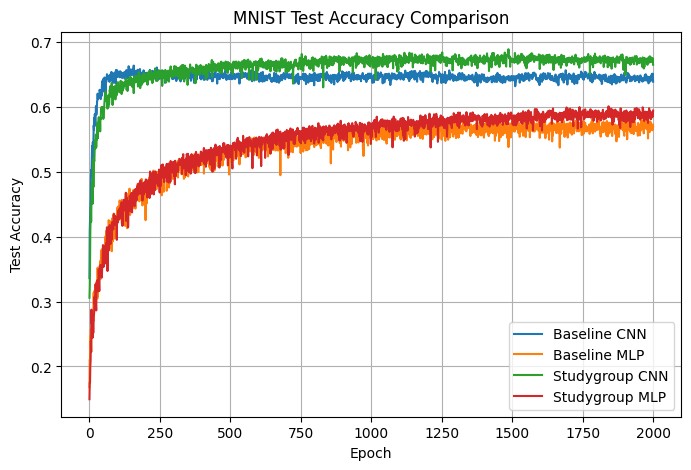

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_cnn"]["test_acc"], label="Baseline CNN")
plt.plot(logs["baseline_mlp"]["test_acc"], label="Baseline MLP")
plt.plot(logs["studygroup_cnn"]["test_acc"], label="Studygroup CNN")
plt.plot(logs["studygroup_mlp"]["test_acc"], label="Studygroup MLP")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.title("MNIST Test Accuracy Comparison")
plt.show()


In [15]:
print(max(logs["baseline_cnn"]["test_acc"]))
print(max(logs["baseline_mlp"]["test_acc"]))
print(max(logs["studygroup_cnn"]["test_acc"]))
print(max(logs["studygroup_mlp"]["test_acc"]))

0.6633
0.5827
0.6885
0.6006


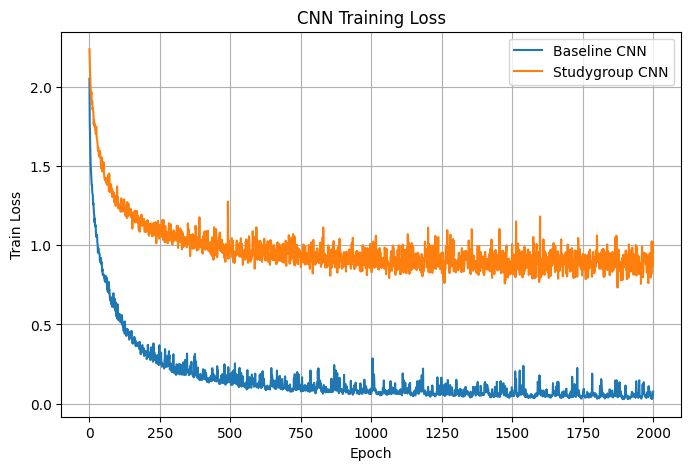

In [16]:
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_cnn"]["train_loss"], label="Baseline CNN")
plt.plot(logs["studygroup_cnn"]["train_loss"], label="Studygroup CNN")

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.title("CNN Training Loss")
plt.show()


In [17]:
cnn_id1 = CNN_CIFAR().to(device)
cnn_id1.load_state_dict(cnn_init_state)
cnn_id2 = CNN_CIFAR().to(device)
cnn_id2.load_state_dict(cnn_init_state)

opt_cnn_id1 = torch.optim.Adam(cnn_id1.parameters(), lr=1e-3)
opt_cnn_id2 = torch.optim.Adam(cnn_id2.parameters(), lr=1e-3)

train_studygroup(
    cnn_id1,
    cnn_id2,
    opt_cnn_id1,
    opt_cnn_id2,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["individual_cnn1"],
    logs["individual_cnn2"],
    T=2.0
)


  0%|          | 0/2000 [00:00<?, ?it/s]

[Studygroup][00] CNN Loss=2.0494, Acc=0.3356 | MLP Loss=2.0491, Acc=0.3345
[Studygroup][01] CNN Loss=1.7969, Acc=0.4030 | MLP Loss=1.8020, Acc=0.3996
[Studygroup][02] CNN Loss=1.6996, Acc=0.4328 | MLP Loss=1.7063, Acc=0.4273
[Studygroup][03] CNN Loss=1.6482, Acc=0.4723 | MLP Loss=1.6677, Acc=0.4637
[Studygroup][04] CNN Loss=1.6024, Acc=0.4666 | MLP Loss=1.6084, Acc=0.4539
[Studygroup][05] CNN Loss=1.5756, Acc=0.4844 | MLP Loss=1.5641, Acc=0.4828
[Studygroup][06] CNN Loss=1.5352, Acc=0.4917 | MLP Loss=1.5525, Acc=0.4933
[Studygroup][07] CNN Loss=1.5002, Acc=0.5006 | MLP Loss=1.4963, Acc=0.5061
[Studygroup][08] CNN Loss=1.4487, Acc=0.5094 | MLP Loss=1.4670, Acc=0.5153
[Studygroup][09] CNN Loss=1.4455, Acc=0.5084 | MLP Loss=1.4426, Acc=0.4992
[Studygroup][10] CNN Loss=1.4182, Acc=0.5339 | MLP Loss=1.4125, Acc=0.5383
[Studygroup][11] CNN Loss=1.3816, Acc=0.5460 | MLP Loss=1.3969, Acc=0.5357
[Studygroup][12] CNN Loss=1.3789, Acc=0.5477 | MLP Loss=1.3803, Acc=0.5500
[Studygroup][13] CNN Loss

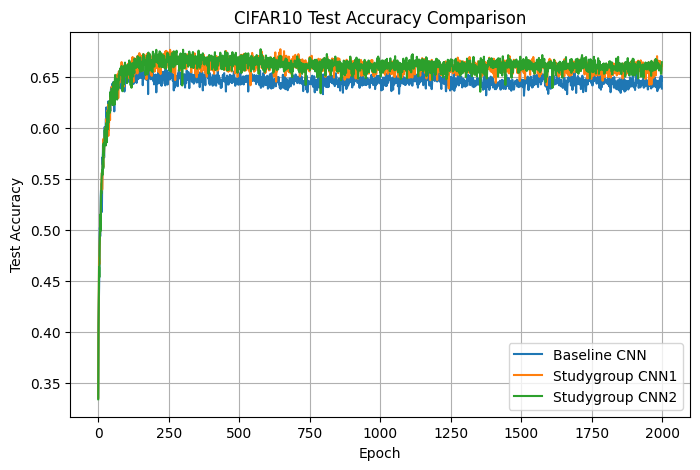

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_cnn"]["test_acc"], label="Baseline CNN")
plt.plot(logs["individual_cnn1"]["test_acc"], label="Studygroup CNN1")
plt.plot(logs["individual_cnn2"]["test_acc"], label="Studygroup CNN2")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.title("CIFAR10 Test Accuracy Comparison")
plt.show()


In [19]:
print(max(logs["baseline_cnn"]["test_acc"]))
print(max(logs["individual_cnn1"]["test_acc"]))
print(max(logs["individual_cnn2"]["test_acc"]))

0.6633
0.677
0.677


In [20]:
mlp_id1 = MLP_CIFAR().to(device)
mlp_id1.load_state_dict(mlp_init_state)
mlp_id2 = MLP_CIFAR().to(device)
mlp_id2.load_state_dict(mlp_init_state)

opt_mlp_id1 = torch.optim.Adam(mlp_id1.parameters(), lr=1e-3)
opt_mlp_id2 = torch.optim.Adam(mlp_id2.parameters(), lr=1e-3)

train_studygroup(
    mlp_id1,
    mlp_id2,
    opt_mlp_id1,
    opt_mlp_id2,
    train_loader,
    test_loader,
    device,
    epochs,
    logs["individual_mlp1"],
    logs["individual_mlp2"],
    T=2.0
)


  0%|          | 0/2000 [00:00<?, ?it/s]

[Studygroup][00] CNN Loss=2.2534, Acc=0.1774 | MLP Loss=2.2534, Acc=0.1774
[Studygroup][01] CNN Loss=2.1949, Acc=0.2059 | MLP Loss=2.1949, Acc=0.2059
[Studygroup][02] CNN Loss=2.1389, Acc=0.2270 | MLP Loss=2.1389, Acc=0.2270
[Studygroup][03] CNN Loss=2.1057, Acc=0.2293 | MLP Loss=2.1057, Acc=0.2293
[Studygroup][04] CNN Loss=2.0741, Acc=0.2741 | MLP Loss=2.0741, Acc=0.2741
[Studygroup][05] CNN Loss=2.0610, Acc=0.2499 | MLP Loss=2.0610, Acc=0.2499
[Studygroup][06] CNN Loss=2.0351, Acc=0.2389 | MLP Loss=2.0351, Acc=0.2389
[Studygroup][07] CNN Loss=2.0167, Acc=0.2819 | MLP Loss=2.0167, Acc=0.2819
[Studygroup][08] CNN Loss=1.9996, Acc=0.2823 | MLP Loss=1.9996, Acc=0.2823
[Studygroup][09] CNN Loss=1.9910, Acc=0.2544 | MLP Loss=1.9910, Acc=0.2544
[Studygroup][10] CNN Loss=1.9938, Acc=0.2760 | MLP Loss=1.9938, Acc=0.2760
[Studygroup][11] CNN Loss=1.9851, Acc=0.2825 | MLP Loss=1.9851, Acc=0.2825
[Studygroup][12] CNN Loss=1.9446, Acc=0.3040 | MLP Loss=1.9446, Acc=0.3040
[Studygroup][13] CNN Loss

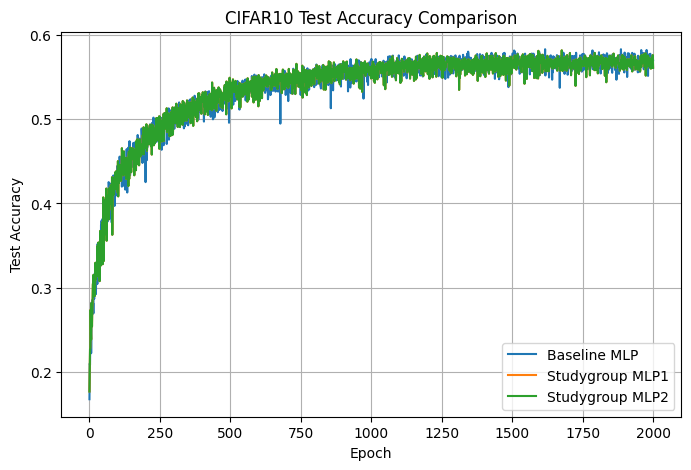

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(logs["baseline_mlp"]["test_acc"], label="Baseline MLP")
plt.plot(logs["individual_mlp1"]["test_acc"], label="Studygroup MLP1")
plt.plot(logs["individual_mlp2"]["test_acc"], label="Studygroup MLP2")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.title("CIFAR10 Test Accuracy Comparison")
plt.show()


In [22]:
print(max(logs["baseline_mlp"]["test_acc"]))
print(max(logs["individual_mlp1"]["test_acc"]))
print(max(logs["individual_mlp2"]["test_acc"]))

0.5827
0.5814
0.5814
